# Home assignment 1 (65 pts)

## Problem 1 (25 pts)
---

Recently generative models have experience dramatic quality in terms of photorealism and quality of image generation
and it is becoming increasingly difficult to distinguish real and generated content.

In this task your goal is to develop a classifier with as high accuracy as possible that classifies whether the given image is real on synthetic.

In the following we will use the dataset from Kaggle [AI Generated Images vs Real Images](https://www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images/data) constructed from images scraped from the web and generated via modern generative models.

### Important notes

* You are allowed to use any pretrained model from `torchvision`, `timm` and `open_clip` . Use of any other source is <font color='red'>prohibited</font> !
* The amount of data is small. Recall the recipes and practices to combat overfitting you learned on lectures and seminars.
* In case you do not have `kaggle` account, create one and follow the instructions on [this page](https://www.kaggle.com/docs/api) to get Kaggle API token.

Prepare kaggle API token

In [ ]:
!pip install kaggle # already installed on Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Put the token in `/.kaggle` directory

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Deep Learning/API/kaggle.json" ~/.kaggle
# !mv kaggle.json ~/.kaggle

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
from typing import Tuple

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Dataset preparation
---

Please <font color='red'>do not change</font> the lines below!

Train and test split are expected to be the same for all submissions.

In [ ]:
# download and extract data
!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images
!unzip ai-generated-images-vs-real-images.zip

 98% 465M/476M [00:03<00:00, 173MB/s]
100% 476M/476M [00:03<00:00, 133MB/s]
Archive:  ai-generated-images-vs-real-images.zip
  inflating: AiArtData/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg  
  inflating: AiArtData/AiArtData/-s-fluffy-fur-and-round-features-immediately-melted-the-viewer-s-heart-photo.jpg  
  inflating: AiArtData/AiArtData/-using-generative-ai-technology-landscape-pattern-abstract-concept-269270897.jpg  
  inflating: AiArtData/AiArtData/-yellow-kimono-with-a-golden-crown-and-a-very-detailed-Barn-owl-copy-800x800.jpg  
  inflating: AiArtData/AiArtData/.amazonaws.com2Fpublic2Fimages2Ff89de3bb-279b-42c9-9822-a653fb5b21e6_600x480.png  
  inflating: AiArtData/AiArtData/0002_AI-in-animal-classification.png  
  inflating: AiArtData/AiArtData/00urban_biodiversity_landscape_architecture_14ed209d-45ca-4c57-b995-4d1552813cc1.jpg  
  inflating: AiArtData/AiArtData/03a3gbCKfH8dDJnjhHLuHDf-1.fit_lim.v1665523315.png  
  inflating: AiArt

In [ ]:
# split train/test data in 75/25% ration
test_ratio = 0.25
# generated images
ai_root = "AiArtData/AiArtData"
ai_paths = [os.path.join(ai_root, path) for path in os.listdir(ai_root)]
ai_labels = [0 for _ in ai_paths]
# real images
real_root = "RealArt/RealArt"
real_paths = [os.path.join(real_root, path) for path in os.listdir(real_root)]
real_labels = [1 for _ in real_paths]
# concatenate
all_img_paths = [*ai_paths, *real_paths]
all_labels = [*ai_labels, *real_labels]

train_img_paths, test_img_paths, train_labels, test_labels = train_test_split(
    all_img_paths, all_labels, test_size=0.25, random_state=42
)

Let us visualize some samples


In [ ]:
import matplotlib.pyplot as plt

Real images

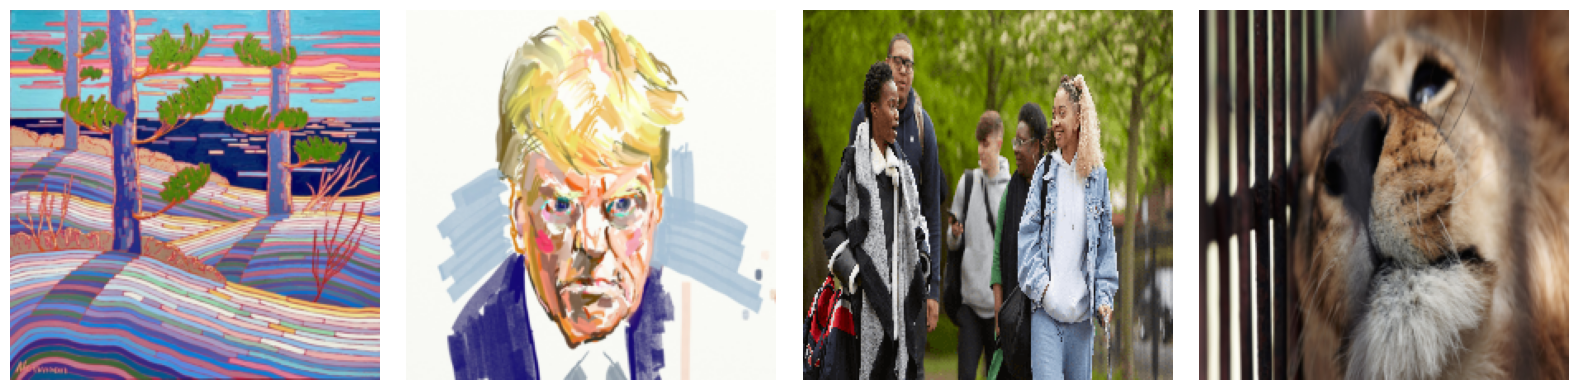

In [ ]:
resize = T.Resize((224, 224))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(real_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

Generated images

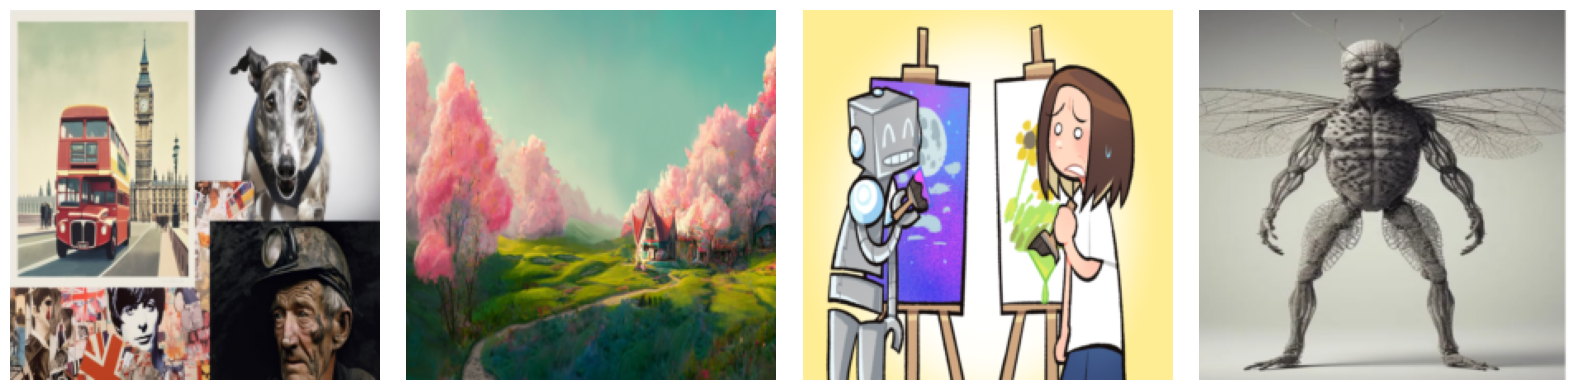

In [ ]:
resize = T.Resize((224, 224))

fig, ax = plt.subplots(ncols=4, figsize=(4 * 4, 4))
for i in range(4):
    img = Image.open(ai_paths[i])
    ax[i].imshow(resize(img))
    ax[i].axis('off')
fig.tight_layout()

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # get image
        image = Image.open(self.img_paths[idx]).convert("RGB")
        # convert image to tensor
        if self.transform:
            image = self.transform(image)
        # get label
        label = self.labels[idx]
        return image, label

We will use ImageNet stats for normalization. (actual `mean` and `std` are quite close to the one for ImageNet)

In [3]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

1. **(1 pt )** Choose any reasonable traning transformation pipeline

In [ ]:
train_transform = T.Compose([
    T.Resize((224, 224)),
    # T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    # T.RandomAdjustSharpness(2),
    T.RandomPerspective(0.2),
    # T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.4)], p=0.8),
    # T.RandomGrayscale(p=0.2),

    # T.Resize(232, interpolation=T.InterpolationMode.BICUBIC),
    # T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)
])
train_dataset = ImageDataset(train_img_paths, train_labels, transform=train_transform)
train_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle=True,
    num_workers=4
)

<font color='red'>Do not change</font> the transformations below! Evaluation setup is expected to be consistent across all submissions.

In [ ]:
test_transforms = T.Compose([
    T.Resize(232, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)]
)
test_dataset = ImageDataset(test_img_paths, test_labels, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2, pin_memory=True)

### Model
---

2. **(1 pt)** Design your own model or take any pretrained, or train from scratch model from `torchvision`, `timm` or `open_clip`.

In [ ]:
!pip install timm
import torchvision.models
import timm
# import timm (you may need !pip install timm)
# import open_clip (you may need !pip install open_clip)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# TODO your code
model = timm.create_model('resnet101', num_classes=1000, pretrained=True)

By default most models in `torchvision` or `timm` have 1000 classes. How many classes are in this case?

3. **(1 pt)** Build a classifier, suitable for a task of interest.

In [ ]:
# TODO your code
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

Prepare training loop and necessary functions.

4. **(1 pt)** Implement metric to measure model performance
5. **(3 pts)** Implement training loop
6. **(2 pts)** Implement validation loop

In [ ]:
# TODO

def binary_accuracy(logits: torch.Tensor, target: torch.Tensor) -> float:
    """
    Args:
        logits - model prediction logits
        target - ground truth labels
    Returns:
        classificiation accuracy
    """
    _, predicted = torch.max(logits, dim=1)
    true_labels = (predicted == target).sum().item()
    return true_labels/len(target)

# TODO
def train_epoch(model, train_loader, optimizer, loss_fn, device, scheduler=None) -> Tuple[float, float]:
    """
    Training loop

    Args:
        model: model
        val_loader: validation loader
        optimizer: optimizer
        loss_fn: loss function
        device: device computations are run
        scheduler: (optional) - if using learning rate scheduler
    """
    # What should you with model on training?
    model.train()
    avg_loss = 0.0
    avg_acc1 = 0.0

    for (inputs, targets) in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        avg_acc1 += binary_accuracy(outputs, targets)

    avg_loss /= len(train_loader)
    avg_acc1 /= len(train_loader)

    if scheduler is not None:
        scheduler.step(avg_loss)


    return avg_loss, avg_acc1

# TODO
def val_epoch(model, val_loader, loss_fn, device) -> Tuple[float, float]:
    """
    Validation loop

    Args:
        model: model
        val_loader: validation loader
        loss_fn: loss function
        device: device computations are run

    Returns:
        Validation loss and accuracy
    """
    # What should you with model on validation?
    model.eval()
    avg_loss = 0.0
    avg_acc = 0.0

    with torch.no_grad():
      for (inputs, targets) in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        avg_loss += loss.item()
        avg_acc += binary_accuracy(outputs, targets)

    avg_loss /= len(val_loader)
    avg_acc /= len(val_loader)

    return avg_loss, avg_acc

Now the goal is achieve as high accuracy as possible.

Set up any number of epochs, learning rate, regularization and other hyperparameters that yield best performance on hold-out data.

**Note**. If you decide to use early stopping, **do not use** ⛔ test data, that in practical cases is not available. You can create `devset` from subset of traning data.

In [ ]:
num_epochs = 50 # TODO

6. **(1 pt)** Prepare optimizer and scheduler.
7. **(1 pt)** Choose suitable loss function.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min')

loss_fn = nn.CrossEntropyLoss()

8. **(max 15 pts)** Final performance.

The grading criteria are the following:
* Test accuracy $\in (0.00, 0.75)$ - **0 pts**
* Test accuracy $\in [0.75, 0.80)$ - **5 pts**
* Test accuracy $\in [0.80, 0.85)$ - **10 pts**
* Test accuracy $\in [0.85, 1.00)$ - **15 pts**

You are expected to provide **all the steps** that lead you to solution, i.e which ideas worked and which did not.

Submissions without decription of the experimental setup and the path that lead to the final result will receive **0 pts** for this section.

In [ ]:
_, devset = torch.utils.data.random_split(train_img_paths, [0.8, 0.2])
val_dataset = ImageDataset(devset, [train_labels[i] for i in devset.indices], transform=test_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, pin_memory=True)

# val_size = int(0.1 * len(train_dataset))
# _, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
best_val_acc = 0.0
best_test_acc = 0.0
stop_iter = 0
early_stopping = 15
for epoch in range(num_epochs):
  print(f"Epoch {epoch}")
  train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device='cuda', scheduler=scheduler)
  print(f"Train loss {train_loss:.3f}. Train acc {train_acc:.3f}")
  val_loss, val_acc = val_epoch(model, val_loader, loss_fn, device=device)
  if val_acc > best_val_acc:
    best_val_acc = val_acc
    stop_iter = 0
  else:
    stop_iter += 1
    if stop_iter >= early_stopping:
      print(f'Final test acc: {best_test_acc:.3f}')
      break
  print(f"Val loss {val_loss:.3f}. Val acc {val_acc:.3f}. Best val acc = {best_val_acc:.3f}")
  test_loss, test_acc = val_epoch(model, test_loader, loss_fn, device=device)
  if test_acc > best_test_acc:
    best_test_acc = test_acc
  print(f"Test loss {test_loss:.3f}. Test acc {test_acc:.3f}. Best test acc = {best_test_acc:.3f}")


Epoch 0
Train loss 0.667. Train acc 0.580
Val loss 0.577. Val acc 0.693. Best val acc = 0.693
Test loss 0.598. Test acc 0.643. Best test acc = 0.643
Epoch 1
Train loss 0.519. Train acc 0.754
Val loss 0.301. Val acc 0.915. Best val acc = 0.915
Test loss 0.572. Test acc 0.750. Best test acc = 0.750
Epoch 2
Train loss 0.289. Train acc 0.887
Val loss 0.291. Val acc 0.889. Best val acc = 0.915
Test loss 0.484. Test acc 0.803. Best test acc = 0.803
Epoch 3
Train loss 0.143. Train acc 0.958
Val loss 0.307. Val acc 0.889. Best val acc = 0.915
Test loss 0.789. Test acc 0.762. Best test acc = 0.803
Epoch 4
Train loss 0.116. Train acc 0.960
Val loss 0.246. Val acc 0.922. Best val acc = 0.922
Test loss 0.841. Test acc 0.779. Best test acc = 0.803
Epoch 5
Train loss 0.113. Train acc 0.959
Val loss 0.308. Val acc 0.915. Best val acc = 0.922
Test loss 0.760. Test acc 0.770. Best test acc = 0.803
Epoch 6
Train loss 0.093. Train acc 0.964
Val loss 0.275. Val acc 0.862. Best val acc = 0.922
Test loss 0.

Your awesome report
---

Firstly, I tried to use a model without early stopping and augmentation tricks except normalization. Number of iterations was 50, learning rate 1e-3, learning rate scheduler with default parameters. It was observed huge overfitting (train acc 1.0, test accuracy 0.791). When, I added early stopping using 20% of train data and data augmentation: random rotation and random perspective. Other augmentation techniques were also tested, but the results were worse. The pretrained 'resnet101' model was used. It was found, that using combination of such hyperparameters as learning rate and weight decay equal to 1e-3 and 1e-5 respectively the test accuracy 0.852 can be achieved.


## Problem 2. Segmentation. (40 pts)

In this task, your challenge is to perform semantic segmentation on images from the [PASCAL Visual Object Classes (VOC)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html) dataset. The PASCAL VOC dataset is a well-known dataset in computer vision that includes images of 20 object categories with annotations for classification, detection, and segmentation tasks. Your objective is to develop a segmentation model capable of accurately identifying and delineating multiple object categories within an image, such as animals, vehicles, and household objects. Download the training/validation data (2GB tar file). All the images are shared in the folder "JPEGImages", and the annotated images are available under the "SegmentationObject" folder. Use the [train.txt](https://drive.google.com/file/d/1upvDgz5cU6A3S7GR17huuqVbmAcj0Aeu/view?usp=sharing) and [test.txt](https://drive.google.com/file/d/19KBwTTN8h9z_LJnfD74mp6_OmPFRSZ4j/view?usp=sharing) files for training and testing your model.

Please follow these guidelines and requirements:

- You may consider resizing images to a manageable resolution (e.g., 512x512 pixels) to streamline the experimentation process. Utilize a standard train-test split as recommended for the PASCAL VOC dataset.
- **(20 pts)** Implement the necessary components of the train-test pipeline, including dataset preparation, model (You can use predefined architectures like Unet), model training, and testing. Assess your model's performance on the test dataset.
  - **(10 pts) Bonus:** your own model, not taken from libraries and not a Unet.
- **(5 pts)** Compute and report the Intersection over Union (IoU) and Dice scores for each category on the test set.
- **(5 pts)** Incorporate image augmentations to enhance model accuracy. You may find augmentation libraries such as Albumentations or Kornia beneficial for this purpose.
- **(2 pts)** Exhibit 4-6 examples of your segmentation results on the test dataset, showcasing the best and worst results based on loss/metrics.
- **(3 pts)** Thoroughly explain your methodological approach to this task. Describe the experiments you conducted, their outcomes, and the reasoning behind your decisions. Evaluate the appropriateness of the metrics you used.
- **(5 pts)** Create a function for model inference that accepts an image path. Verify your model's effectiveness on several external images not from the dataset, to gauge its generalizability.
- Refrain from using models that are pre-trained on the PASCAL VOC dataset to maintain the integrity of the competition.
- **Bonus Points:**
  - **+10 points** for attaining the top-1 result.
  - **+8 points** for achieving 2nd or 3rd place.
  - **+5 points** for ranking 4th to 8th, based on the reported mean Dice score on your chosen test split.


In [4]:
path = '/content/drive/MyDrive/Deep Learning/HW'
datapath = f'{path}/VOCdevkit/VOC2012'
img_path, ann_path, mask_path = [os.path.join(datapath, target) for target in ['JPEGImages', 'Annotations', 'SegmentationClass']]

In [ ]:
!tar -xvf "{path}/VOCtrainval_11-May-2012.tar" -C "{path}"

In [5]:
img_transforms = T.Compose([
    T.Resize((256, 256)),
    T.transforms.ToTensor(),
    T.Normalize(mean=mean, std=std)
])
mask_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

In [6]:
class PascalVOCSegmentationDataset(Dataset):
    def __init__(self, img_path, mask_path, target_path, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.target_path = target_path
        self.transform = transform
        with open(target_path, "r") as file:
            self.target_list = [line.strip() for line in file.readlines()]

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        img_name = self.target_list[idx]
        img_path = os.path.join(self.img_path, img_name+'.jpg')
        mask_path = os.path.join(self.mask_path, img_name+'.png')

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)

        # # Convert the mask to a one-hot encoding
        # mask = torch.zeros(21, img.size(1), img.size(2))
        # mask[mask_path] = 1

        return img, mask

In [13]:
train_dataset = PascalVOCSegmentationDataset(img_path, mask_path, f"{path}/train.txt", transform=img_transforms)
test_dataset = PascalVOCSegmentationDataset(img_path, mask_path, f"{path}/test.txt", transform=img_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
class Encoder_Block(torch.nn.Module):
  def __init__(self,inp_channels,out_channels):
    super().__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
    )
    self.pooling = torch.nn.MaxPool2d(2)

  def forward(self,x):
    int_out = self.model(x)
    return self.pooling(int_out), int_out

class Decoder_Block(torch.nn.Module):
  def __init__(self,inp_channels,out_channels):
    super().__init__()
    self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
    )
  def forward(self,x,enc_x):
    x = torch.nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
    # x = torch.cat([x, enc_x], dim=1)
    # x = self.upsample(x)
    x = torch.cat([x,enc_x],dim=1)
    return self.model(x)

class Unet(torch.nn.Module):
  def __init__(self,inc,outc,hidden_size=64):
    super().__init__()
    self.Encoder = torch.nn.ModuleList([
        Encoder_Block(inc,hidden_size),
        Encoder_Block(hidden_size,hidden_size*2),
        Encoder_Block(hidden_size*2,hidden_size*4),
        Encoder_Block(hidden_size*4,hidden_size*8),
    ])
    self.bottleneck = torch.nn.Sequential(
        torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
        torch.nn.BatchNorm2d(hidden_size*16),
        torch.nn.ReLU(),
        torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
        torch.nn.BatchNorm2d(hidden_size*16),
        torch.nn.ReLU()
    )
    self.Decoder = torch.nn.ModuleList([
        Decoder_Block(hidden_size*16,hidden_size*8),
        Decoder_Block(hidden_size*8,hidden_size*4),
        Decoder_Block(hidden_size*4,hidden_size*2),
        Decoder_Block(hidden_size*2,hidden_size*1),
    ])
    self.last_layer = torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same")
  def forward(self,x):
    enc_xs = []
    for module in self.Encoder:
      x, enc_x= module(x)
      enc_xs.append(enc_x)

    enc_xs = enc_xs[::-1]
    x = self.bottleneck(x)

    for i,module in enumerate(self.Decoder):
      x = module(x,enc_xs[i])
    return self.last_layer(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(3,3).to(device)

In [10]:
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
def DiceIou(y_pred, y_true, mode):
  intersection = y_pred * y_true
  tempsum = y_pred + y_true
  union = tempsum - intersection
  smooth = 1e-8
  if mode is 'dice':
    return 2*intersection.sum() / (tempsum.sum() + smooth)
  elif mode is 'iou':
    return intersection.sum() / (union.sum() + smooth)
  else:
    raise Exception("Unknown metric")

def train_epoch(model, train_loader, optimizer, loss_fn, device, scheduler=None) -> Tuple[float, float, float]:

    model.train()
    avg_loss = 0.0
    avg_iou = 0.0
    avg_dice = 0.0

    for (inputs, targets) in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        avg_iou += DiceIou(outputs, targets, mode='iou')
        avg_dice += DiceIou(outputs, targets, mode='dice')

    avg_loss /= len(train_loader)
    avg_iou /= len(train_loader)
    avg_dice /= len(train_loader)

    if scheduler is not None:
        scheduler.step(avg_loss)

    return avg_loss, avg_iou, avg_dice

# TODO
def val_epoch(model, val_loader, loss_fn, device) -> Tuple[float, float, float]:

    model.eval()
    avg_loss = 0.0
    avg_iou = 0.0
    avg_dice = 0.0

    with torch.no_grad():
      for (inputs, targets) in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        avg_loss += loss.item()
        avg_iou += DiceIou(outputs, targets, mode='iou')
        avg_dice += DiceIou(outputs, targets, mode='dice')

    avg_loss /= len(val_loader)
    avg_iou /= len(train_loader)
    avg_dice /= len(train_loader)

    return avg_loss, avg_iou, avg_dice

In [14]:
# best_val_acc = 0.0
best_test_iou = 0.0
best_test_dice = 0.0
stop_iter = 0
for epoch in range(num_epochs):
  print(f"Epoch {epoch}")
  train_loss, train_iou, train_dice = train_epoch(model, train_loader, optimizer, loss_fn, device=device, scheduler=None)
  print(f"Train loss {train_loss:.3f}. Train iou {train_iou:.3f}. Train dice {train_iou:.3f}")
  test_loss, test_iou, test_dice = val_epoch(model, test_loader, loss_fn, device=device)
  if test_iou > best_test_iou: best_test_iou = test_iou
  if test_dice > best_test_dice: best_test_dice = test_dice
  print(f"Test loss {test_loss:.3f}. Test iou {test_iou:.3f}. Test dice {test_dice:.3f}. Best test iou = {best_test_iou:.3f}. Best test dice = {best_test_dice:.3f}")

Epoch 0
Train loss -3405.052. Train iou -0.602. Train dice -0.602
Test loss -4818.026. Test iou -0.598. Test dice -3.091. Best test iou = 0.000. Best test dice = 0.000
Epoch 1
Train loss -8378.403. Train iou -0.603. Train dice -0.603
Test loss -11336.870. Test iou -0.592. Test dice -3.014. Best test iou = 0.000. Best test dice = 0.000
Epoch 2
Train loss -15452.262. Train iou -0.604. Train dice -0.604
Test loss -18485.576. Test iou -0.598. Test dice -3.090. Best test iou = 0.000. Best test dice = 0.000
Epoch 3
Train loss -24393.029. Train iou -0.605. Train dice -0.605
Test loss -27417.939. Test iou -0.596. Test dice -3.055. Best test iou = 0.000. Best test dice = 0.000
Epoch 4
Train loss -35055.694. Train iou -0.604. Train dice -0.604
Test loss -40594.317. Test iou -0.597. Test dice -3.069. Best test iou = 0.000. Best test dice = 0.000
Epoch 5
Train loss -47245.970. Train iou -0.606. Train dice -0.606
Test loss -52005.007. Test iou -0.601. Test dice -3.117. Best test iou = 0.000. Best t